In [249]:
import pandas as pd
import matplotlib.pyplot as plt

In [250]:
def pretty_print_nanoseconds(ns):

    if ns > 1_000_000:
        return f"{ns / 1_000_000:.4f}ms"
    elif ns > 1_000:
        return f"{ns / 1_000:.4f}µs"
    else:
        return f"{ns}ns"

In [ ]:
# Load the data from the file into a DataFrame
file_path = '../log_active_analysis/packet_timestamps.txt'
ts_mapping = pd.read_csv(file_path, delimiter=' ', header=None)

ts_mapping.columns = ['pn', 'ts']
ts_mapping = ts_mapping[1:]

# Interpret both columns as integers
ts_mapping = ts_mapping.astype(int)

# Display the first few rows of the DataFrame
print(ts_mapping.head())


   pn                   ts
1   0  1730802523760220291
2   2  1730802523766004753
3   3  1730802523766009782
4   4  1730802523766206152
5   5  1730802523766216602


In [252]:
missing_packets = []
for i in range(1, len(ts_mapping)-1):
    if ts_mapping['pn'][i]+1 != ts_mapping['pn'][i+1]:
        missing_packets.append(ts_mapping['pn'][i]+1)

print(len(missing_packets))
print(missing_packets[:10])

256
[1, 14, 26, 28, 59, 109, 112, 171, 176, 285]


In [ ]:
# Load the data from the file into a DataFrame
file_path = '../log_active_analysis/retransmission_mapping_go.txt'
go_mappings = pd.read_csv(file_path, delimiter=' ', header=None)

go_mappings.columns = ['old_pn', 'new_pn']
go_mappings = go_mappings[1:]

# Interpret both columns as integers
go_mappings = go_mappings.astype(int)

# Display the first few rows of the DataFrame
print(go_mappings.head())
print(go_mappings.tail())

   old_pn  new_pn
1      14       9
2      26      12
3      28      13
4      59      16
5     109      18
     old_pn  new_pn
176   10923     297
177   11077     300
178   11172     302
179   11196     303
180   11202     305


In [ ]:
# Load the data from the file into a DataFrame
file_path = '../log_active_analysis/retransmission_mapping_ebpf.txt'

# Make empty dataframe
ebpf_mappings = pd.DataFrame(columns = ['old_pn', 'new_pn'], dtype=int)


with open(file_path, 'r') as file:
    for line in file:
        line = line[69:]
        line = line.replace(",", "")
        line = line.replace("Old packet number: ", "")
        line = line.replace("New packet number: ", "")
        old_pn, new_pn = map(int, line.split())
        ebpf_mappings = pd.concat([ebpf_mappings, pd.DataFrame({'old_pn': old_pn, 'new_pn': new_pn}, index=[0])], ignore_index=True)


# Display the first few rows of the DataFrame
print(ebpf_mappings.head())
print(ebpf_mappings.tail())

   old_pn  new_pn
0       1       2
1       2       3
2       3       4
3       4       5
4       5       6
     old_pn  new_pn
276     277   10073
277     278   10102
278     279   10112
279     280   10113
280     281   10143


In [255]:
ts_mapping

,pn,ts
1,0,1730802523760220291
2,2,1730802523766004753
3,3,1730802523766009782
4,4,1730802523766206152
5,5,1730802523766216602
...,...,...
11576,11815,1730802586899159843
11577,11816,1730802586899160083
11578,11817,1730802586899160364
11579,11818,1730802586899160474


In [256]:
ts_mapping = ts_mapping.sort_values(by=['pn'])
ts_mapping = ts_mapping.reset_index(drop=True)

In [257]:
# Form: (index) -> (pn, earliest ts, latest ts)
# If pn was received earliest = latest = ts
expected_ranges = {}
next_pn = ts_mapping['pn'][1]
last_pn = -1
last_ts = -1
i = 1

while i < len(ts_mapping):
    pn = ts_mapping['pn'][i]
    ts = ts_mapping['ts'][i]
    assert pn >= next_pn, f"pn = {pn}, next_pn = {next_pn}"
    if pn == next_pn:
        expected_ranges[next_pn] = (ts, ts)
        last_pn = pn
        last_ts = ts
        i += 1
    else:
        expected_ranges[next_pn] = (last_ts, ts)

    next_pn = next_pn + 1


In [258]:
retransmission_mappings = pd.DataFrame()
go_index = 1
intermediate = {}

while go_index < len(go_mappings):
    old_go, new_go = go_mappings['old_pn'][go_index], go_mappings['new_pn'][go_index]
    go_index += 1

    if old_go in intermediate:
        continue

    while 1:
        translation_series = ebpf_mappings[ebpf_mappings['old_pn'] == new_go]['new_pn']
        if translation_series.empty:
            break
        translation = translation_series.values[0]
        a, b = expected_ranges[translation]
        if a == b:
            retransmission_mappings = pd.concat([retransmission_mappings, pd.DataFrame({'old_pn': old_go, 'new_pn': translation}, index=[0])], ignore_index=True)
            break

        intermediate[translation] = True
        
        new_go = go_mappings[go_mappings['old_pn'] == translation]['new_pn']
        if new_go.empty:
            break
        new_go = new_go.values[0]

In [259]:
retransmission_mappings
missing_packets[-40:-30]

[10019, 10046, 10062, 10080, 10112, 10136, 10245, 10283, 10340, 10382]

In [260]:
merged_mappings = pd.merge(go_mappings, ebpf_mappings, left_on='new_pn', right_on='old_pn', how='inner')

merged_mappings = merged_mappings.drop(columns=['new_pn_x', 'old_pn_y'])
merged_mappings.columns = ['lost_pn', 'retransmit_pn']

merged_mappings.head()

,lost_pn,retransmit_pn
0,14,17
1,26,35
2,28,36
3,59,62
4,109,119


In [261]:
for i in range(1, len(go_mappings)-1):
    if go_mappings['old_pn'][i] not in merged_mappings['lost_pn'].values:
        print(f"Old: {go_mappings['old_pn'][i]}, New: {go_mappings['new_pn'][i]}")
    

Old: 10340, New: 283
Old: 10382, New: 284
Old: 10389, New: 286
Old: 10501, New: 288
Old: 10591, New: 290
Old: 10670, New: 292
Old: 10809, New: 295
Old: 10923, New: 297
Old: 11077, New: 300
Old: 11172, New: 302


In [262]:
actual_translations = pd.DataFrame(columns = ['lost_pn', 'retransmit_pn'], dtype=int)

for i in range(1, len(merged_mappings)):
    lost_pn = merged_mappings['lost_pn'][i]
    retransmit_pn = merged_mappings['retransmit_pn'][i]
    while retransmit_pn in merged_mappings['lost_pn'].values:
        print(f"Multiple retranmits for pn: {retransmit_pn}")
        retransmit_pn = merged_mappings[merged_mappings['lost_pn'] == retransmit_pn]['retransmit_pn'].values[0]
    actual_translations = pd.concat([actual_translations, pd.DataFrame({'lost_pn': lost_pn, 'retransmit_pn': retransmit_pn}, index=[0])], ignore_index=True)
    

Multiple retranmits for pn: 653
Multiple retranmits for pn: 1074


In [263]:
test = pd.merge(merged_mappings, merged_mappings, left_on='retransmit_pn', right_on='lost_pn', how='inner')
test

,lost_pn_x,retransmit_pn_x,lost_pn_y,retransmit_pn_y
0,640,653,653,671
1,1068,1074,1074,1093


In [264]:
for i in range(0, len(merged_mappings)-1):
    if merged_mappings['retransmit_pn'][i] in merged_mappings['lost_pn'].values:
        print(f"Old: {merged_mappings['lost_pn'][i]}, New: {merged_mappings['retransmit_pn'][i]}")

Old: 640, New: 653
Old: 1068, New: 1074


In [265]:
merged_mappings.to_csv('test.csv', index=False)

In [266]:
final_mapping = actual_translations.loc[actual_translations.groupby('retransmit_pn')['lost_pn'].idxmin()]

# Reset index if needed
final_mapping = final_mapping.reset_index(drop=True)

In [267]:
retransmit_data = pd.DataFrame(columns = ['lost_pn', 'retransmit_pn', 'min_expected_ts', 'max_expected_ts', 'retransmission_ts', 'min_delay', 'max_delay', 'delay_spread'], dtype=int)

for i in range(1, len(final_mapping)):
    lost_pn = final_mapping['lost_pn'][i]
    retransmit_pn = final_mapping['retransmit_pn'][i]
    min_expected_ts = expected_ranges[lost_pn][0]
    max_expected_ts = expected_ranges[lost_pn][1]

    if expected_ranges[retransmit_pn][0] != expected_ranges[retransmit_pn][1]:
        print(f"Weird retransmit pn: {retransmit_pn}")
        continue
    retransmission_ts = expected_ranges[retransmit_pn][0]

    min_delay = retransmission_ts - max_expected_ts
    max_delay = retransmission_ts - min_expected_ts

    retransmit_data = pd.concat([retransmit_data, pd.DataFrame({'lost_pn': lost_pn, 
                                                                'retransmit_pn': retransmit_pn, 
                                                                'min_expected_ts': min_expected_ts, 
                                                                'max_expected_ts': max_expected_ts, 
                                                                'retransmission_ts': retransmission_ts,
                                                                'min_delay': min_delay,
                                                                'max_delay': max_delay,
                                                                'delay_spread': max_delay - min_delay}, index=[0])], ignore_index=True)

In [268]:
k = [x for x in expected_ranges.keys() if expected_ranges[x][0] != expected_ranges[x][1]]
len(k)

239

In [269]:
len(missing_packets)

256

In [270]:
print(len(retransmit_data))
print(retransmit_data.head())

164
   lost_pn  retransmit_pn      min_expected_ts      max_expected_ts  \
0       28             36  1730802523845590574  1730802523845590735   
1       59             62  1730802523925684132  1730802523925684382   
2      109            119  1730802524086845652  1730802524086870569   
3      112            120  1730802524086870939  1730802524086871190   
4      171            180  1730802524246848580  1730802524246860783   

     retransmission_ts  min_delay  max_delay  delay_spread  
0  1730802523852991861    7401126    7401287           161  
1  1730802523933000709    7316327    7316577           250  
2  1730802524093428247    6557678    6582595         24917  
3  1730802524093438657    6567467    6567718           251  
4  1730802524253493663    6632880    6645083         12203  


Longest retransmission difference: 72.6084ms
Shortest retransmission difference: 1.1515ms


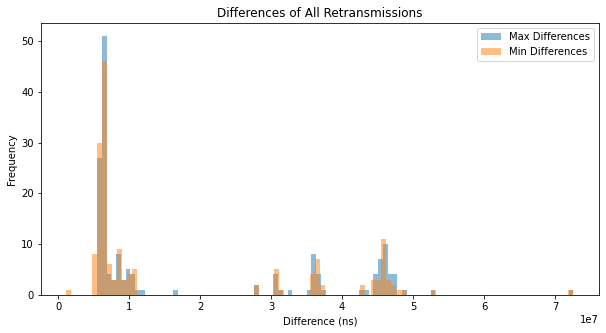

In [271]:
# Plot all differences
max_diffs = retransmit_data['max_delay']
min_diffs = retransmit_data['min_delay']

print("Longest retransmission difference:", pretty_print_nanoseconds(max(max_diffs)))
print("Shortest retransmission difference:", pretty_print_nanoseconds(min(min_diffs)))

# make histogram of differences
plt.figure(figsize=(10, 5))
plt.hist(max_diffs, bins=100, alpha=0.5, label='Max Differences')
plt.hist(min_diffs, bins=100, alpha=0.5, label='Min Differences')
plt.xlabel('Difference (ns)')
plt.ylabel('Frequency')
plt.title('Differences of All Retransmissions')
plt.legend()

plt.show()


Longest retransmission delay spread: 41.1330ms
Shortest retransmission delay spread: 120ns


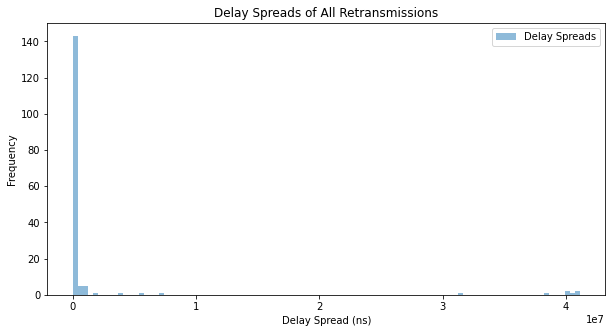

In [274]:
# Plot all delay spreads
delay_spreads = retransmit_data['delay_spread']

print("Longest retransmission delay spread:", pretty_print_nanoseconds(max(delay_spreads)))
print("Shortest retransmission delay spread:", pretty_print_nanoseconds(min(delay_spreads)))

# make histogram of delay spreads
plt.figure(figsize=(10, 5))
plt.hist(delay_spreads, bins=100, alpha=0.5, label='Delay Spreads')

plt.xlabel('Delay Spread (ns)')
plt.ylabel('Frequency')
plt.title('Delay Spreads of All Retransmissions')
plt.legend()

plt.show()

In [272]:
long_delay_pns = retransmit_data[retransmit_data['min_delay'] > 2e7]

In [273]:
# TODO: why are some taking longer without multiple retransmissions?
long_delay_pns[:10]

,lost_pn,retransmit_pn,min_expected_ts,max_expected_ts,retransmission_ts,min_delay,max_delay,delay_spread
14,640,671,1730802525405344456,1730802525405355808,1730802525450845846,45490038,45501390,11352
22,1068,1093,1730802526246058483,1730802526246058613,1730802526290764374,44705761,44705891,130
25,1236,1261,1730802526606608944,1730802526606609204,1730802526652091538,45482334,45482594,260
26,1280,1309,1730802526686980074,1730802526687199677,1730802526731841809,44642132,44861735,219603
27,1292,1310,1730802526726103494,1730802526726103734,1730802526762528973,36425239,36425479,240
28,1368,1391,1730802526846575344,1730802526846612423,1730802526892420851,45808428,45845507,37079
34,1660,1694,1730802527446745571,1730802527446746142,1730802527492644520,45898378,45898949,571
35,1666,1695,1730802527446747776,1730802527446748176,1730802527492651132,45902956,45903356,400
36,1776,1808,1730802527646139442,1730802527646148610,1730802527691707247,45558637,45567805,9168
41,1944,1974,1730802528006033857,1730802528006226330,1730802528051986837,45760507,45952980,192473


In [275]:
long_delay_spreads = retransmit_data[retransmit_data['delay_spread'] > 2e7]

In [276]:
long_delay_spreads

,lost_pn,retransmit_pn,min_expected_ts,max_expected_ts,retransmission_ts,min_delay,max_delay,delay_spread
24,1210,1212,1730802526566922935,1730802526598380780,1730802526599532328,1151548,32609393,31457845
42,1991,2004,1730802528087024794,1730802528125472301,1730802528132783869,7311568,45759075,38447507
44,2329,2346,1730802529005340441,1730802529046250545,1730802529052330835,6080290,46990394,40910104
132,7483,7493,1730802537804733060,1730802537844739753,1730802537851974115,7234362,47241055,40006693
146,8920,8937,1730802543885164133,1730802543925171707,1730802543931550829,6379122,46386696,40007574
152,9492,9508,1730802545964802619,1730802546005523486,1730802546011319219,5795733,46516600,40720867
160,9896,9914,1730802547324334425,1730802547365467377,1730802547371279551,5812174,46945126,41132952
